<a href="https://colab.research.google.com/github/lorenzosintini/4YP/blob/master/CVAE_MNIST_Numbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import Libraries

In [0]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys

#### Import Data (and select part of it only)

In [0]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

choose_class = 1
crop_input = 1
classes_to_pick = [4]
data_inputs = 1000

def pick_class(x_train, y_train, class_n):
  pics = (y_train == class_n[0])
  for i in range(len(classes_to_pick)-1):
    pics = pics + (y_train == class_n[i+1])
  new_x_train=x_train[pics]
  new_y_train=y_train[pics]
  return new_x_train, new_y_train

if choose_class == 1:
  x_train, y_train = pick_class(x_train, y_train, classes_to_pick)

if crop_input == 1:
  x_train = x_train[0:-1]
  y_train = y_train[0:-1]

#### Define Data Size and Classes

In [0]:
# INPUT DATA
class_names = ['Zero','One', 'Two', 'Three', 'Four', 'Five','Six', 'Seven', 'Eight', 'Nine']
N_image_channels = 1

N_train = len(y_train)
N_test = len(y_test)
N_class = len(class_names)
image_shape = x_train.shape[1:3]
input_range = np.amax(x_train)

#### Plot images from set (random or in order)

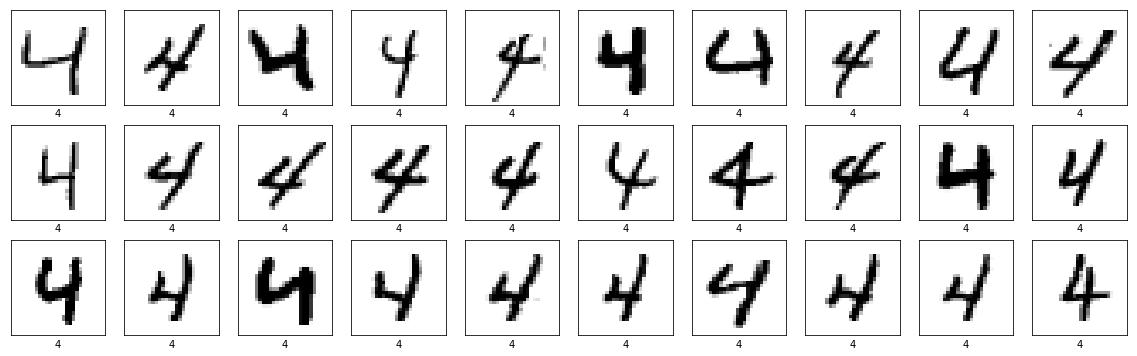

In [564]:
def plot_images(x_train, y_train, figures_to_plot=10, pick_random=False, include_labels=True):
    n_rows = np.ceil(figures_to_plot/10)
    plot = plt.figure(figsize=[20,2*n_rows])
    for i in range(figures_to_plot):
        if pick_random: 
            pic_n = random.randint(0,len(x_train))
        else: pic_n = i
        plt.subplot(n_rows,10,i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(x_train[pic_n], cmap=plt.cm.binary)
        if include_labels:
            plt.xlabel(y_train[pic_n])
    plt.show()

plot_images(x_train, y_train, 30)

#### Pre-Proces Data

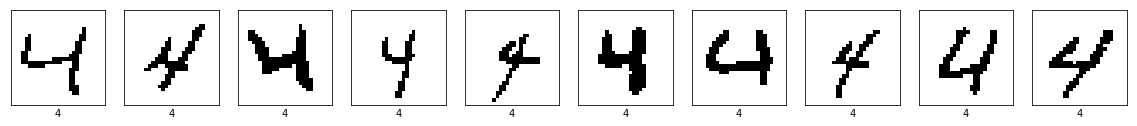

In [565]:
train_images = x_train/input_range
test_images = x_test/input_range

def set_pixels_binary(images):
    images[images >= 0.5] = 1.0
    images[images < 0.5] = 0.0
    return images

train_images = set_pixels_binary(train_images)
test_images = set_pixels_binary(test_images)
train_labels = y_train
test_labels = y_test

plot_images(train_images, train_labels, 10)

train_images = train_images.reshape(N_train, image_shape[0], image_shape[1], N_image_channels).astype('float32')
test_images = test_images.reshape(N_test, image_shape[0], image_shape[1], N_image_channels).astype('float32')

#### Create Dataset

In [0]:
batch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((train_images)).shuffle(N_train).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images)).shuffle(N_test).batch(batch_size)

#### Create Variational Autoencoder (VAE) Model

In [567]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([ 
                          tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
                          tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(z_size*2)
                          ])

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Dense(units=24*24*64, activation='relu', input_shape=(z_size,)),
                          tf.keras.layers.Reshape(target_shape=(24, 24, 64)),
                          tf.keras.layers.Conv2DTranspose(32, (3,3), activation='relu'),
                          tf.keras.layers.Conv2DTranspose(1, (3,3)),
                          ])
    @tf.function
    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled
    
    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        pixel_prob = tf.math.sigmoid(pixel_output)
        return pixel_prob

z_size = 10
model = CVAE(z_size)
model.encoder_nn.summary()
model.decoder_nn.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
flatten_8 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 20)                737300    
Total params: 756,116
Trainable params: 756,116
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 36864)             405504    
________________________

#### Define the loss function 

In [0]:
@tf.function
def calculate_ELBO(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    
    pixel_prob = model.decode(z)
    
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*x + tf.math.log(1-pixel_prob + 1e-10)*(1-x)
    logpx_z_images = tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    logpx_z = tf.reduce_mean (logpx_z_images)
    
    KL_parameters = -0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    KL = tf.reduce_mean(KL_vectors)
    
    ELBO = (logpx_z - KL)
    
    return -ELBO #Negative because we want to maximise it

#### Define the optimizer

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

#### Define loss metrics

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

#### Define train and test steps

In [0]:
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_ELBO(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)
        
@tf.function
def test_step(model, x, optimizer):
    loss = calculate_ELBO(model, x)
    test_loss(loss)

In [0]:
#### Generate random image from latent vector

In [0]:
def generate_images(model, z_random, figures_to_plot):
    generated_prob = model.decode(z_random)
    generated_prob = np.squeeze(generated_prob, axis=3)
    plot_images(generated_prob, _, figures_to_plot=figures_to_plot, include_labels=False)

#### Train the data

Epoch 1 progress (%): 100.0
Train ELBO: -247.84881591796875;
Test ELBO: -244.40130615234375;
Generated images:


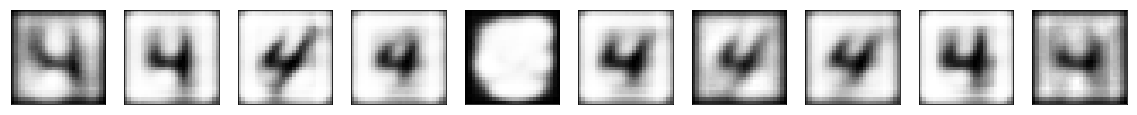

Epoch 2 progress (%): 100.0
Train ELBO: -194.3731689453125;
Test ELBO: -233.3217315673828;
Generated images:


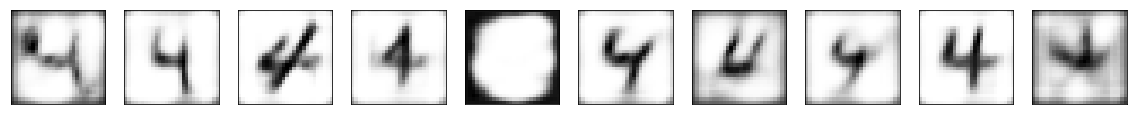

Epoch 3 progress (%): 100.0
Train ELBO: -164.0894775390625;
Test ELBO: -225.30055236816406;
Generated images:


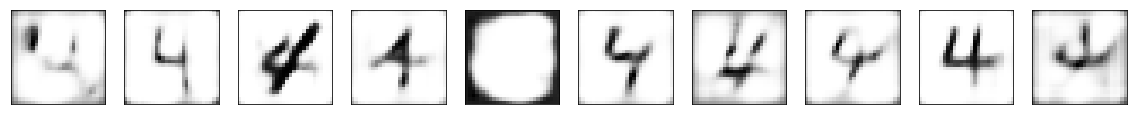

Epoch 4 progress (%): 100.0
Train ELBO: -145.4765625;
Test ELBO: -222.32830810546875;
Generated images:


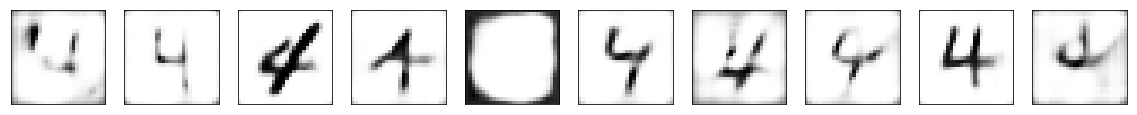

Epoch 5 progress (%): 100.0
Train ELBO: -133.37582397460938;
Test ELBO: -221.12777709960938;
Generated images:


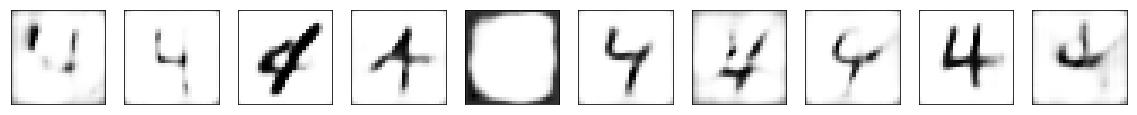

Epoch 6 progress (%): 100.0
Train ELBO: -124.8298568725586;
Test ELBO: -220.77841186523438;
Generated images:


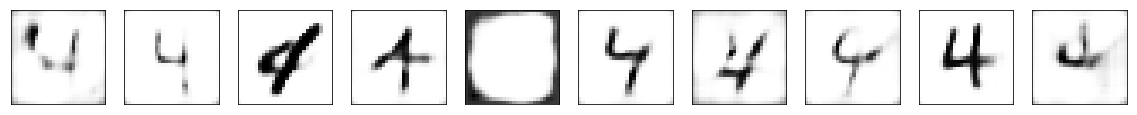

Epoch 7 progress (%): 100.0
Train ELBO: -118.41144561767578;
Test ELBO: -221.490966796875;
Generated images:


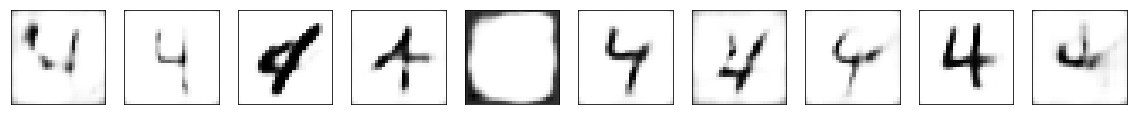

Epoch 8 progress (%): 100.0
Train ELBO: -113.40018463134766;
Test ELBO: -222.0224151611328;
Generated images:


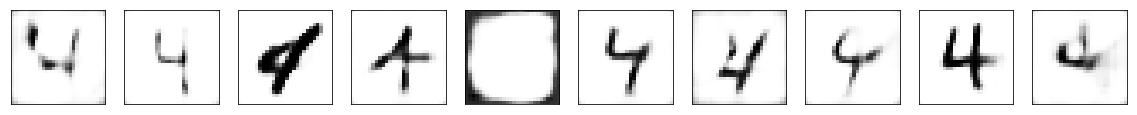

Epoch 9 progress (%): 100.0
Train ELBO: -109.372802734375;
Test ELBO: -222.611083984375;
Generated images:


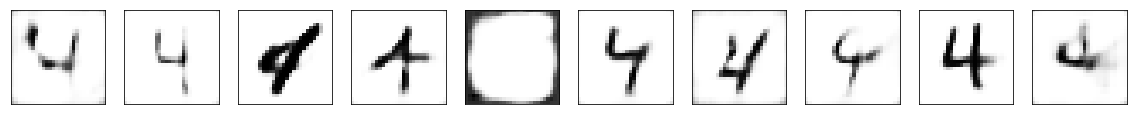

Epoch 10 progress (%): 100.0
Train ELBO: -106.0325698852539;
Test ELBO: -223.6920928955078;
Generated images:


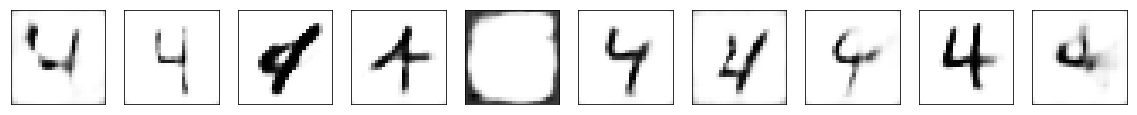

Epoch 11 progress (%): 100.0
Train ELBO: -103.22634887695312;
Test ELBO: -224.19725036621094;
Generated images:


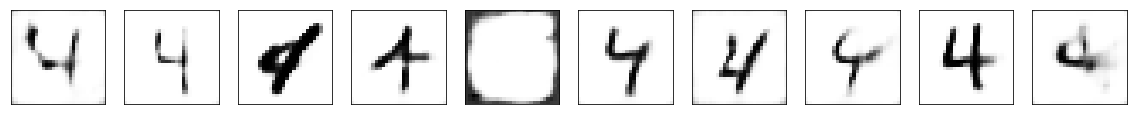

Epoch 12 progress (%): 100.0
Train ELBO: -100.82453918457031;
Test ELBO: -224.8425750732422;
Generated images:


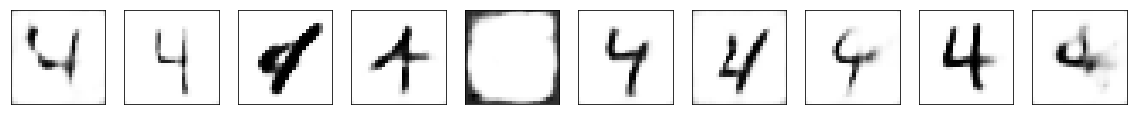

Epoch 13 progress (%): 100.0
Train ELBO: -98.73255157470703;
Test ELBO: -225.7975311279297;
Generated images:


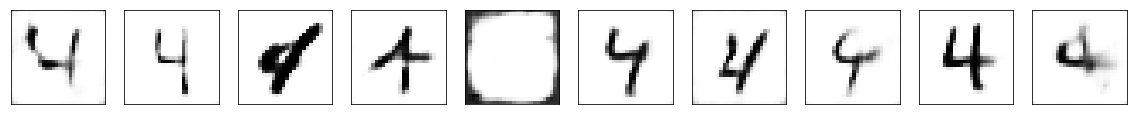

Epoch 14 progress (%): 100.0
Train ELBO: -96.90079498291016;
Test ELBO: -226.75723266601562;
Generated images:


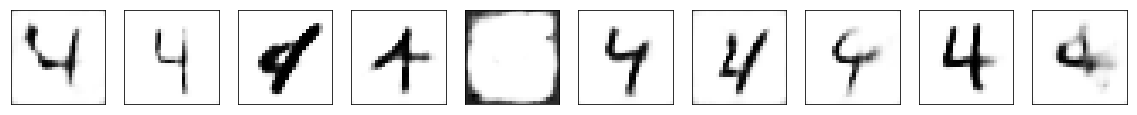

Epoch 15 progress (%): 100.0
Train ELBO: -95.27123260498047;
Test ELBO: -227.7045440673828;
Generated images:


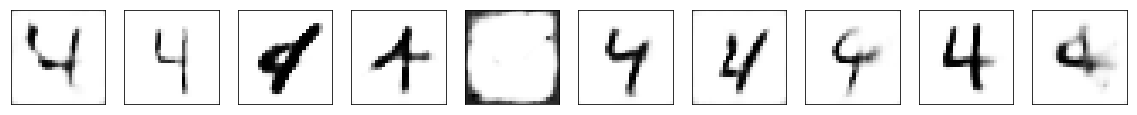

Epoch 16 progress (%): 100.0
Train ELBO: -93.81766510009766;
Test ELBO: -228.18507385253906;
Generated images:


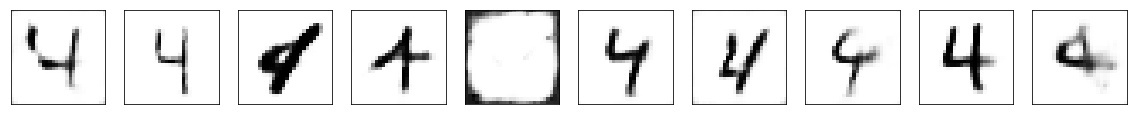

Epoch 17 progress (%): 100.0
Train ELBO: -92.50406646728516;
Test ELBO: -228.99090576171875;
Generated images:


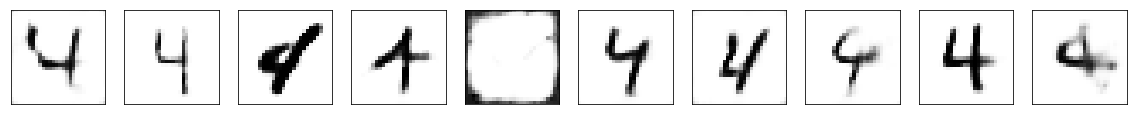

Epoch 18 progress (%): 100.0
Train ELBO: -91.3102035522461;
Test ELBO: -229.78256225585938;
Generated images:


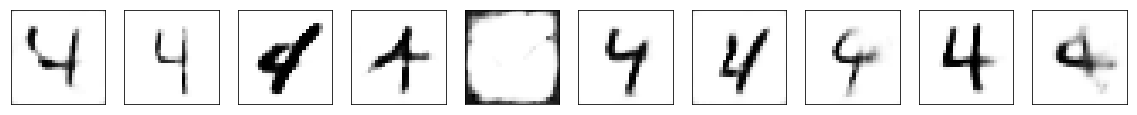

Epoch 19 progress (%): 100.0
Train ELBO: -90.21102142333984;
Test ELBO: -230.55538940429688;
Generated images:


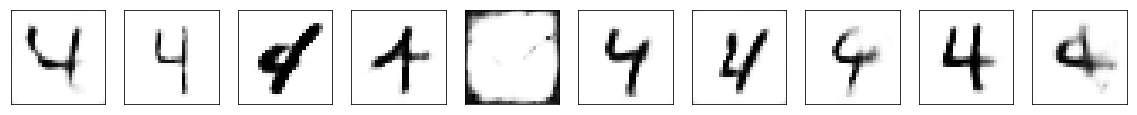

Epoch 20 progress (%): 100.0
Train ELBO: -89.20170593261719;
Test ELBO: -231.1186981201172;
Generated images:


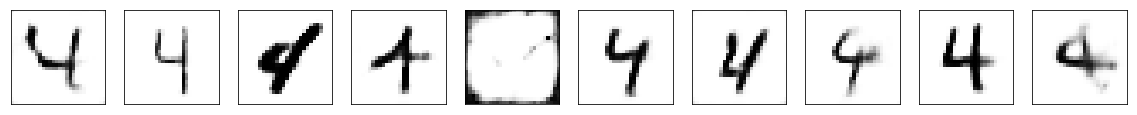

Epoch 21 progress (%): 100.0
Train ELBO: -88.26971435546875;
Test ELBO: -231.82322692871094;
Generated images:


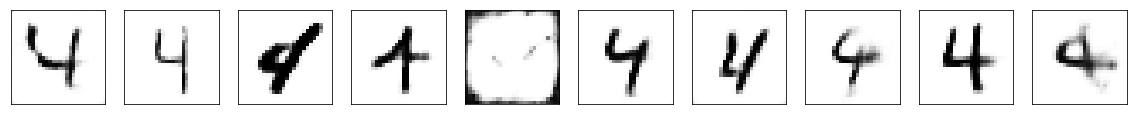

Epoch 22 progress (%): 100.0
Train ELBO: -87.4052963256836;
Test ELBO: -232.6923370361328;
Generated images:


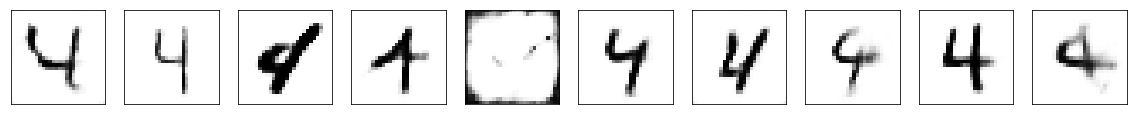

Epoch 23 progress (%): 100.0
Train ELBO: -86.59909057617188;
Test ELBO: -233.4131317138672;
Generated images:


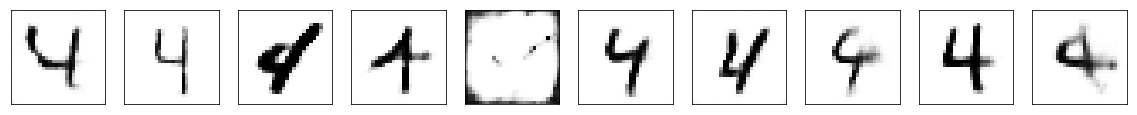

Epoch 24 progress (%): 100.0
Train ELBO: -85.84532165527344;
Test ELBO: -234.2584686279297;
Generated images:


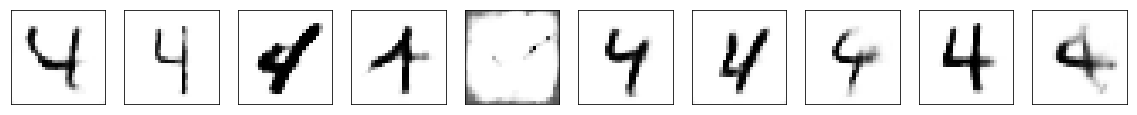

Epoch 25 progress (%): 100.0
Train ELBO: -85.14083862304688;
Test ELBO: -235.21090698242188;
Generated images:


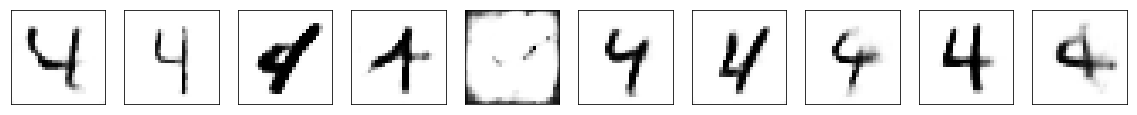

Epoch 26 progress (%): 100.0
Train ELBO: -84.47502136230469;
Test ELBO: -236.00619506835938;
Generated images:


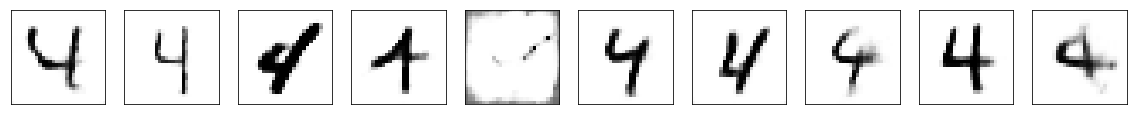

Epoch 27 progress (%): 100.0
Train ELBO: -83.84437561035156;
Test ELBO: -237.1790008544922;
Generated images:


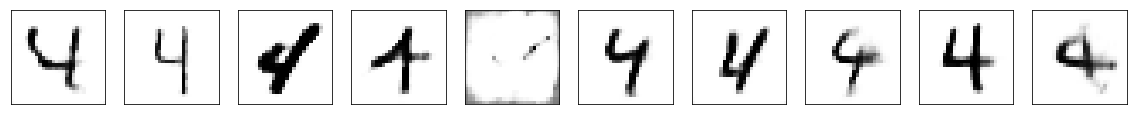

Epoch 28 progress (%): 100.0
Train ELBO: -83.24260711669922;
Test ELBO: -237.90943908691406;
Generated images:


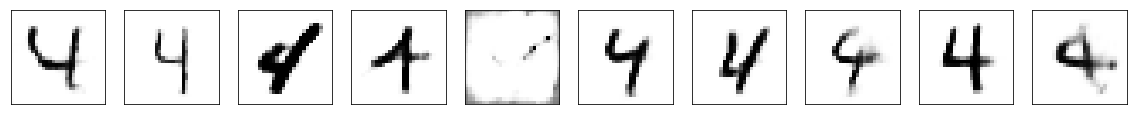

Epoch 29 progress (%): 100.0
Train ELBO: -82.66669464111328;
Test ELBO: -238.6641387939453;
Generated images:


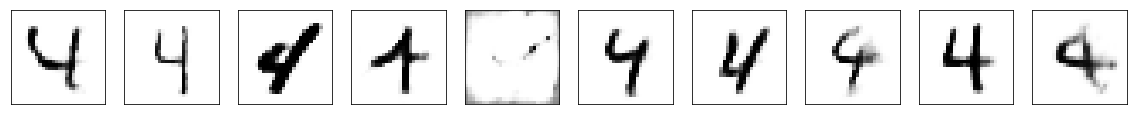

Epoch 30 progress (%): 100.0
Train ELBO: -82.11654663085938;
Test ELBO: -239.46551513671875;
Generated images:


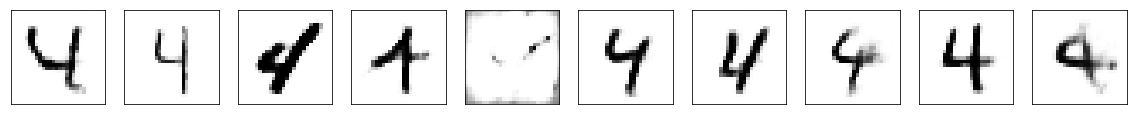

Epoch 31 progress (%): 100.0
Train ELBO: -81.6008529663086;
Test ELBO: -240.19686889648438;
Generated images:


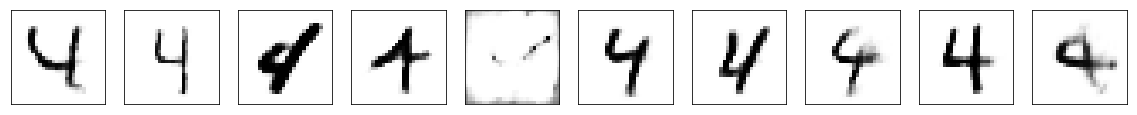

Epoch 32 progress (%): 100.0
Train ELBO: -81.10235595703125;
Test ELBO: -241.13778686523438;
Generated images:


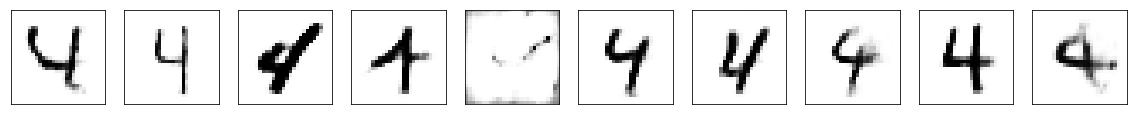

Epoch 33 progress (%): 100.0
Train ELBO: -80.62181091308594;
Test ELBO: -242.224609375;
Generated images:


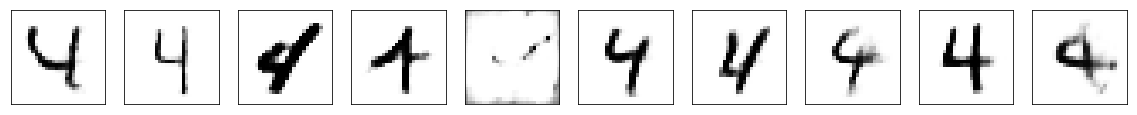

Epoch 34 progress (%): 100.0
Train ELBO: -80.16029357910156;
Test ELBO: -243.23822021484375;
Generated images:


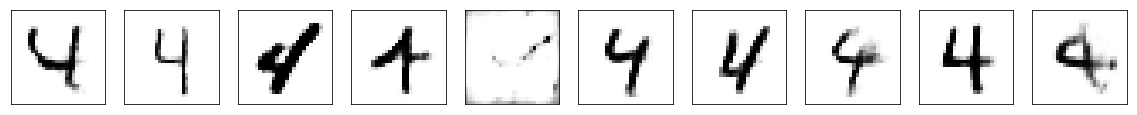

Epoch 35 progress (%): 100.0
Train ELBO: -79.72074890136719;
Test ELBO: -244.3472900390625;
Generated images:


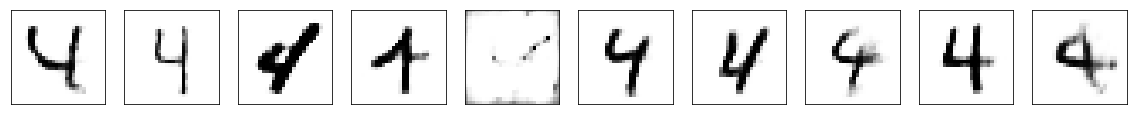

Epoch 36 progress (%): 100.0
Train ELBO: -79.2933349609375;
Test ELBO: -245.19541931152344;
Generated images:


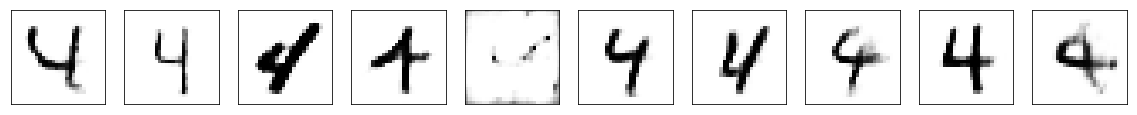

Epoch 37 progress (%): 100.0
Train ELBO: -78.87957000732422;
Test ELBO: -246.16587829589844;
Generated images:


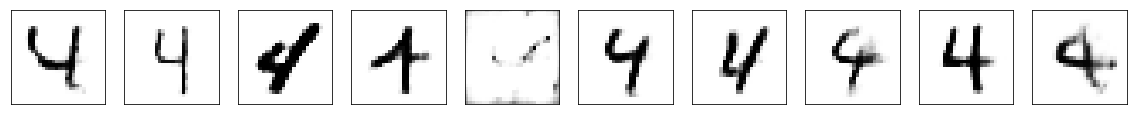

Epoch 38 progress (%): 100.0
Train ELBO: -78.48258972167969;
Test ELBO: -247.2445526123047;
Generated images:


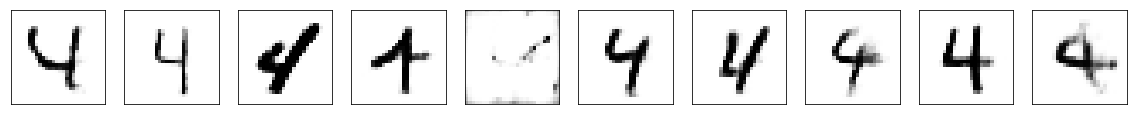

Epoch 39 progress (%): 100.0
Train ELBO: -78.09379577636719;
Test ELBO: -248.2617645263672;
Generated images:


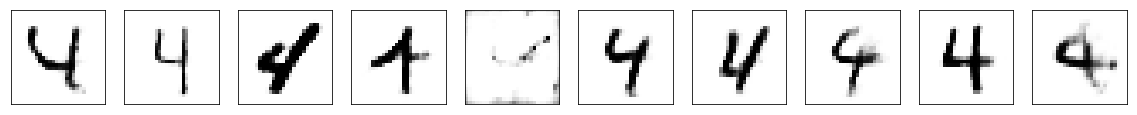

Epoch 40 progress (%): 100.0
Train ELBO: -77.71918487548828;
Test ELBO: -249.2979736328125;
Generated images:


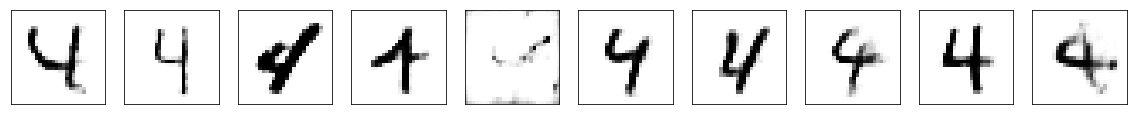

In [574]:
epochs = 40
plots_per_epoch = 10
z_random = tf.random.normal(shape=[plots_per_epoch, z_size])

for epoch in range(epochs):
    for i, train_x in enumerate(train_dataset): 
        sys.stdout.write('\r'+'Epoch {} progress (%): {}'.format(epoch+1,100*(i+1)/(np.ceil(N_train/batch_size))))
        sys.stdout.flush()
        train_step(model, train_x, optimizer)

    for i, test_x in enumerate(test_dataset):
        test_step(model, test_x, optimizer)
    
    print('\nTrain ELBO: {};\nTest ELBO: {};\nGenerated images:'.format(-train_loss.result(), -test_loss.result()))
    
    generate_images(model, z_random, plots_per_epoch)

In [0]:
#### Reconstruct image

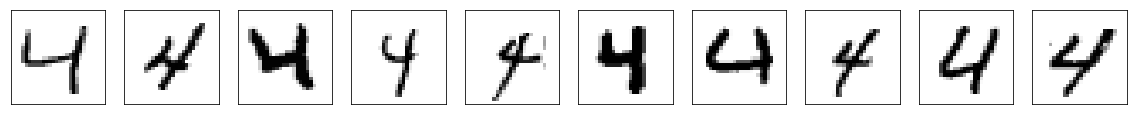

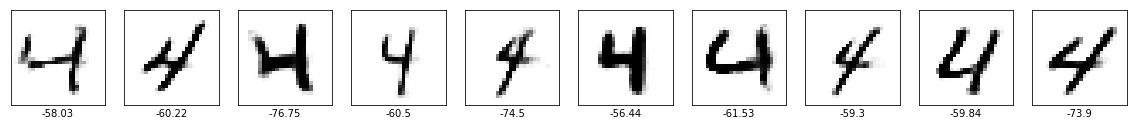

In [576]:
def reconstruct_images(range1, range2):
    images_to_pick = range(range1,range2)
    y = x_train[images_to_pick]
    x = train_images[images_to_pick]
    loss = np.empty([len(images_to_pick)])

    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_output = model.decode(z)
    pixel_prob = tf.math.sigmoid(pixel_output)
    pixel_prob = np.squeeze(pixel_prob, axis=3)

    for i in range(len(images_to_pick)):
        loss[i] = calculate_ELBO(model,x[i:i+1])

    loss = loss.astype('float16')
    plot_images(y, _, figures_to_plot=len(images_to_pick), include_labels=False)
    plot_images(pixel_prob, -loss, figures_to_plot=len(images_to_pick), include_labels=True)

reconstruct_images(0,10)


0


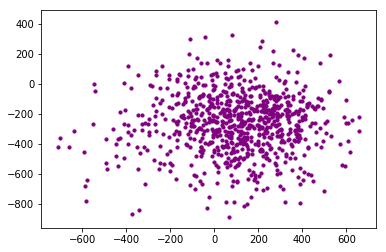

In [578]:
def visualize_latent_space(range1, range2, a, b):
  outliers=0
  for i in range(range1, range2):
    pic_visualize = x_train[i]
    pic_visualize = pic_visualize.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    z_mean, z_logvar = model.encode(pic_visualize)
    if any(z_logvar[:,i]>5 for i in range(10)):
      outliers +=1
      continue
    z = model.reparameterize(z_mean, z_logvar)
    if y_train[i] == 0:
      color = 'blue'
    if y_train[i] == 1:
      color = 'orange'
    if y_train[i] == 2:
      color = 'green'
    if y_train[i] == 3:
      color = 'red'
    if y_train[i] == 4:
      color = 'purple'  
    if y_train[i] == 5:
      color = 'brown'
    if y_train[i] == 6:
      color = 'pink'
    if y_train[i] == 7:
      color = 'gray'
    if y_train[i] == 8:
      color = 'black'
    if y_train[i] == 9:
      color = 'yellow'
    plt.scatter(z[:,a],z[:,b], color=color, s=10)
  print(outliers)

visualize_latent_space(0,50,0,1)
  

In [0]:
#plot_images(x_train, y_train, 50)
a=[]